# <center> Capstone проект. Идентификация пользователей по посещенным веб-страницам

В этом проекте решается задача идентификации пользователя по его поведению в сети Интернет. Это сложная и интересная задача на стыке анализа данных и поведенческой психологии. В качестве примера, компания Яндекс решает задачу идентификации взломщика почтового ящика по его поведению. В двух словах, взломщик будет себя вести не так, как владелец ящика: он может не удалять сообщения сразу по прочтении, как это делал хозяин, он будет по-другому ставить флажки сообщениям и даже по-своему двигать мышкой. Тогда такого злоумышленника можно идентифицировать и "выкинуть" из почтового ящика, предложив хозяину войти по SMS-коду. Похожие вещи делаются, например, в Google Analytics.

По последовательности из нескольких веб-сайтов, посещенных подряд один и тем же человеком, идентифицируется человек. Идея такая: пользователи Интернета по-разному переходят по ссылкам, и это может помогать их идентифицировать (кто-то сначала в почту, потом про футбол почитать, затем новости, контакт, потом наконец – работать, кто-то – сразу работать).

Будем использовать данные из [статьи](http://ceur-ws.org/Vol-1703/paper12.pdf) "A Tool for Classification of Sequential Data".

Данные пришли с прокси-серверов Университета Блеза Паскаля и имеют очень простой вид. Для каждого пользователя заведен csv-файл с названием user\*\*\*\*.csv (где вместо звездочек – 4 цифры, соответствующие ID пользователя), а в нем посещения сайтов записаны в следующем формате: <br>

<center>*timestamp, посещенный веб-сайт*</center>


**Поставим задачу классификации: идентифицировать пользователя по сессии из 10 подряд посещенных сайтов. Объектом в этой задаче будет сессия из 10 сайтов и времени их посещения, последовательно посещенных одним и тем же пользователем, признаками – индексы этих 10 сайтов и 'timestamp' посещеных сайтов (чуть позже здесь появится "мешок" сайтов, подход Bag of Words). Целевым классом будет один из пользователей. Цель спрогнозировать бинарный признак target (пользователь=alice)**

Загрузим необходимые для работы библиотеки.

In [269]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import os
import pickle
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import SGDClassifier,LogisticRegressionCV,LogisticRegression
from sklearn.metrics import roc_auc_score,roc_curve,confusion_matrix
from tqdm import tqdm
from scipy.sparse import csr_matrix,hstack
from sklearn.feature_extraction.text import CountVectorizer
import imblearn
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

Считаем данные из csv файла.

In [2]:
PATH_TO_DATA = 'catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/'

In [3]:
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'),
                       index_col='session_id')
test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'),
                      index_col='session_id')

In [4]:
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,...,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,...,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,...,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,...,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0


Объединим обучающую и тестовую выборки – это понадобится, чтоб вместе потом привести их к разреженному формату.

In [4]:
train_test_df = pd.concat([train_df, test_df])

В обучающей выборке – 2297 сессий одного пользователя (Alice) и 251264 сессий – других пользователей, не Элис. Дисбаланс классов очень сильный, и смотреть на долю верных ответов (accuracy) непоказательно.


In [5]:
train_df['target'].value_counts()

0    251264
1      2297
Name: target, dtype: int64

Отбираем только признаки с сайтами и сохраняем, чтобы потом использовать алгоритм bag of words.

In [7]:
train_test_df_sites = train_test_df[['site%d' % i for i in range(1, 11)]].fillna(0).astype('int')

In [8]:
train_test_df_sites.to_csv('train_sessions_text.txt', 
                                 sep=' ', index=None, header=None)

In [142]:
%%time
# CountVectorizer из sklearn выполняет алгоритм мешка слов
cv = CountVectorizer(ngram_range=(1,3),max_features=100000)
with open('train_sessions_text.txt') as inp_train_file:
    X = cv.fit_transform(inp_train_file)

CPU times: user 12.4 s, sys: 280 ms, total: 12.7 s
Wall time: 12.7 s


Делим датасет на обучающую и тестовую выборку.

In [143]:
X_train_sparse = X[:train_df.shape[0]]
X_test_sparse = X[train_df.shape[0]:train_test_df_sites.shape[0]]
y = train_df.target
train_share = int(.7 * X_train_sparse.shape[0])
X_train, y_train = X_train_sparse[:train_share, :], y[:train_share]
X_valid, y_valid  = X_train_sparse[train_share:, :], y[train_share:]

Результат до добавления признаков.

In [144]:
sgd_logit = SGDClassifier(loss='log',random_state=17,n_jobs=-1)
sgd_logit.fit(X_train,y_train)
logit_valid_pred_proba = sgd_logit.predict_proba(X_valid)[:,1]
roc_auc_score(y_valid,logit_valid_pred_proba)

0.9390413705411895

Новые признаки, образованные от значений времени посещения сайта.

In [10]:
extra_feats = train_test_df[[f'time{i}' for i in range(1,11)]].fillna(0).astype(str)

Преобразование в тип данных timestamp, чтобы потом удобнее было извлекать информацию  (час, месяц, день недели и тд)

In [11]:
extra_feats = extra_feats.apply(lambda x:pd.to_datetime(x,errors='coerce'))

In [12]:
extra_feats['month'] = extra_feats.iloc[:,0].apply(lambda x:x.month)
extra_feats['hour'] = extra_feats.iloc[:,0].apply(lambda x:x.hour)
extra_feats['day_of_week'] = extra_feats.iloc[:,0].apply(lambda x:x.weekday())
extra_feats['morning'] = ((extra_feats['hour'] >= 7) & (extra_feats['hour']  <= 11)).astype('int')
extra_feats['day'] = ((extra_feats['hour'] >= 12) & (extra_feats['hour']  <= 18)).astype('int')
extra_feats['evening'] = ((extra_feats['hour'] >= 19) & (extra_feats['hour']  <= 23)).astype('int')
extra_feats['summer'] = ((extra_feats['month'] >= 6) & (extra_feats['month'] <= 8)).astype('int')
for i in tqdm(range(9)):
    extra_feats.iloc[:,i] = extra_feats.iloc[:,i+1] - extra_feats.iloc[:,i]
    extra_feats.iloc[:,i] = extra_feats.iloc[:,i].apply(lambda x:x.total_seconds())

extra_feats['session_timespan'] = extra_feats.iloc[:,range(10)].sum(axis=1)
extra_feats['weekend'] = (extra_feats['day_of_week'] >= 5).astype(int)
extra_feats['evening_session'] = (extra_feats['hour'] >= 18).astype(int)
extra_feats.drop([f'time{i}' for i in range(1,11)],axis=1,inplace=True)

100%|██████████| 9/9 [00:23<00:00,  2.60s/it]


In [13]:
extra_feats.fillna(0,inplace=True)

Первые 5 строк новых признаков.

In [14]:
extra_feats.head()

,month,hour,day_of_week,morning,day,evening,summer,session_timespan,weekend,evening_session
session_id,,,,,,,,,,
1,2,10,3,1,0,0,0,0.0,0,0
2,2,11,5,1,0,0,0,26.0,1,0
3,12,16,0,0,1,0,0,7.0,0,0
4,3,10,4,1,0,0,0,270.0,0,0
5,2,10,4,1,0,0,0,246.0,0,0


Визуализация признаков

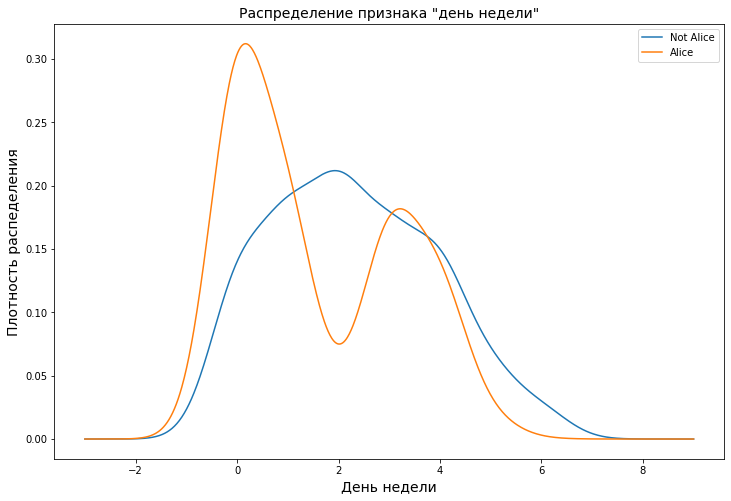

In [28]:
plt.figure(figsize=(12,8))
extra_feats.loc[:train_df.shape[0]]['day_of_week'].groupby(y).plot.kde(bw_method=0.35)
plt.xlabel('День недели',fontsize=14)
plt.ylabel('Плотность распеделения',fontsize=14)
plt.title('Распределение признака "день недели"',fontsize=14)
plt.legend(labels=['Not Alice','Alice']);

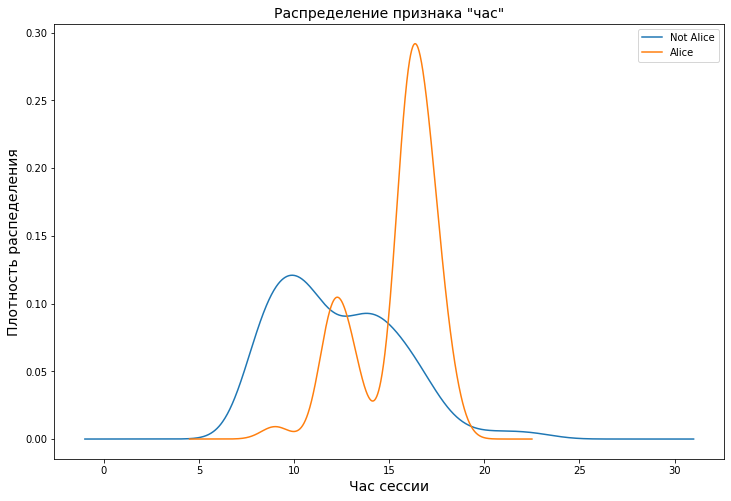

In [29]:
plt.figure(figsize=(12,8))
extra_feats.loc[:train_df.shape[0]]['hour'].groupby(y).plot.kde(bw_method=0.35)
plt.xlabel('Час сессии',fontsize=14)
plt.ylabel('Плотность распеделения',fontsize=14)
plt.title('Распределение признака "час"',fontsize=14)
plt.legend(labels=['Not Alice','Alice']);

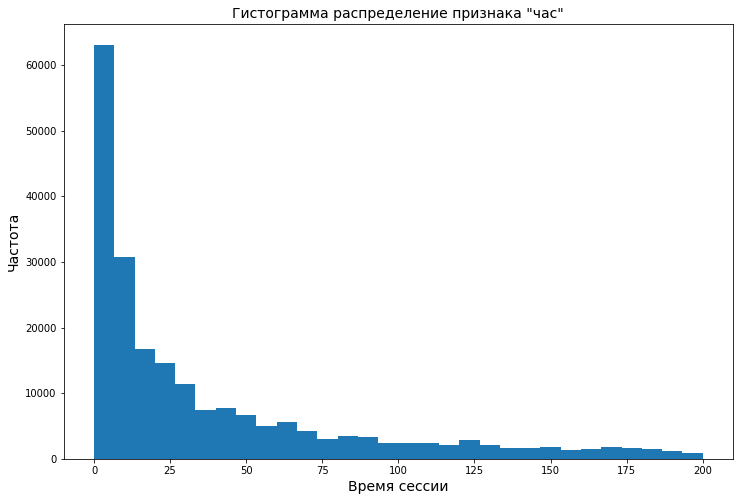

In [34]:
plt.figure(figsize=(12,8))
extra_feats.loc[:train_df.shape[0]]['session_timespan'].plot.hist(bins=30,range=(0,200))
plt.xlabel('Время сессии',fontsize=14)
plt.ylabel('Частота',fontsize=14)
plt.title('Гистограмма распределение признака "час"',fontsize=14);

Выкинем признак времени сессии, так как он негативно влияет на результат модели.

In [35]:
extra_feats.drop('session_timespan',axis=1,inplace=True)

Средние значения признаков в зависимости от юзера (Alice или нет)

In [37]:
extra_feats.iloc[:train_df.shape[0]].groupby(y)[['month', 'hour', 'day_of_week', 
                                                 'morning', 'day','evening', 'summer',
                                                 'weekend', 'evening_session']].mean().T


target,0,1
month,4.498647,5.893774
hour,12.259731,15.433609
day_of_week,2.296186,1.584676
morning,0.485083,0.017849
day,0.486058,0.982151
evening,0.028858,0.000000
summer,0.010041,0.000000
weekend,0.091891,0.018285
evening_session,0.043659,0.077928


Как мы можем видеть Alice предпочитает посещать сайты днём, в выходные отдыхать, а утром спать.

Объединим все признаки.

In [145]:
X_train_sparse = X[:train_df.shape[0]]
X_test_sparse = X[train_df.shape[0]:train_test_df_sites.shape[0]]
y = train_df.target

In [146]:
extra_feats_train = csr_matrix(extra_feats)[:train_df.shape[0]]
extra_feats_test = csr_matrix(extra_feats)[train_df.shape[0]:train_test_df_sites.shape[0]]

In [147]:
X_train_sparse = hstack((X_train_sparse,extra_feats_train))
X_test_sparse = hstack((X_test_sparse,extra_feats_test))

Undersampling помогает в борьбе с дизбалансом классов. Случайным образом убирает определенное количество объектов доминирующего класса. После преобразования модели проще найти различие между классами при обучении.

In [148]:
under = RandomUnderSampler(sampling_strategy={0:50000})
X_train_sparse,y = under.fit_resample(X_train_sparse,y)

In [149]:
X_train, X_valid , y_train , y_valid  = train_test_split(X_train_sparse,y,random_state=17,stratify=y)

Сильный дизбаланс классов. Немного подправляется с помощью class_weight.

In [150]:
y_train.value_counts()

0    37499
1     1723
Name: target, dtype: int64

roc_auc = 0.94 до добавления  признаков.

In [151]:
sgd_logit = SGDClassifier(loss='log',random_state=17,n_jobs=-1,class_weight={0:1,1:3},alpha=2.5e-5)
sgd_logit.fit(X_train,y_train)
logit_valid_pred_proba = sgd_logit.predict_proba(X_valid)[:,1]
roc_auc_score(y_valid,logit_valid_pred_proba)

0.9742791308402644

In [248]:
logit = LogisticRegressionCV(random_state=17,n_jobs=-1,class_weight={0:1,1:3},scoring='roc_auc')
logit.fit(X_train,y_train)
logit_valid_pred_proba = logit.predict_proba(X_valid)[:,1]
roc_auc_score(y_valid,logit_valid_pred_proba)

0.9770985568541276

Оптимальное значение  С в окрестности 1 

C optimal: 0.359


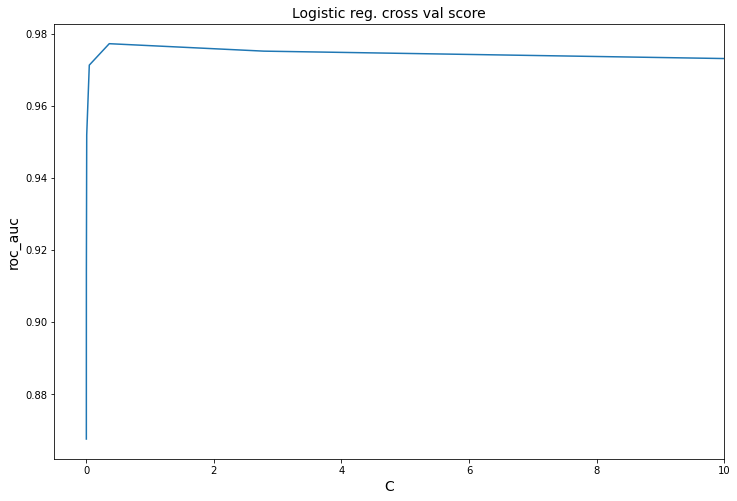

In [249]:
plt.figure(figsize=(12,8))
plt.plot(logit.Cs_,logit.scores_[1].mean(axis=0))
plt.xlabel('C',fontsize=14)
plt.ylabel('roc_auc',fontsize=14)
plt.title('Logistic reg. cross val score',fontsize=14)
plt.xlim(-0.5,10)
print('C optimal: {}'.format(round(logit.Cs_[np.argmax(logit.scores_[1].mean(axis=0))],3)));

Теперь найдём лучшее значение C

In [250]:
logit_c_values1 = np.linspace(0.2, 0.8, 20)

In [251]:
logit = LogisticRegressionCV(Cs = logit_c_values1, random_state=17,n_jobs=-1,class_weight={0:1,1:3},scoring='roc_auc')
logit.fit(X_train,y_train)
logit_valid_pred_proba = logit.predict_proba(X_valid)[:,1]
roc_auc_score(y_valid,logit_valid_pred_proba)

0.9770614866490124

C optimal: 0.358


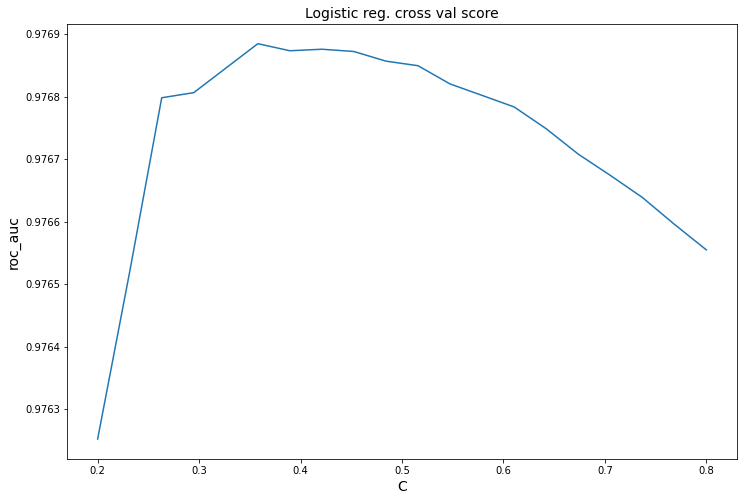

In [252]:
plt.figure(figsize=(12,8))
plt.plot(logit.Cs_,logit.scores_[1].mean(axis=0))
plt.xlabel('C',fontsize=14)
plt.ylabel('roc_auc',fontsize=14)
plt.title('Logistic reg. cross val score',fontsize=14)
print('C optimal: {}'.format(round(logit.Cs_[np.argmax(logit.scores_[1].mean(axis=0))],3)));

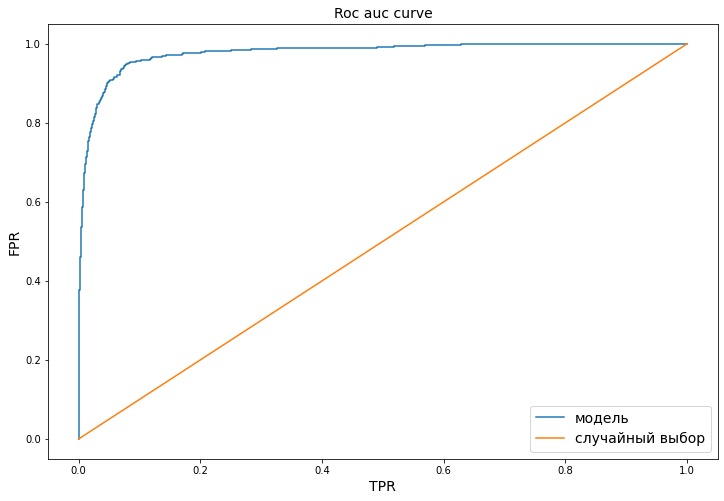

In [277]:
roc_auc = roc_curve(y_valid,logit_valid_pred_proba)
plt.figure(figsize=(12,8))
plt.plot(roc_auc[0],roc_auc[1])
plt.plot([0,1])
plt.xlabel('TPR',fontsize=14)
plt.ylabel('FPR',fontsize=14)
plt.title('Roc auc curve',fontsize=14)
plt.legend(labels=['модель','случайный выбор'],fontsize=14);

Модель хорошо определяет Alice и других пользователей (значение roc auc близко к 1)

Полученная модель способна прогнозировать пользователя. Если, одинм из пользователь ведёт какую-то подозрительную активность. Модель поможет понять мошенник это или нет. В случае обнаружения мошенника, можно предпринять действия по блокировке человека или смс оповещении и тд. Основное применение: обеспечение безопасности.

Идеи, которые могут улучшить качество модели:
   1. Придумать больше признаков  
   2. Попробовать использовать другое преобразование сайтов (td idf)
   3. Использовать сложные алгоритмы (xgboost/catboost, нейросеть)
   4. Проверить другие аглоритмы undersampling'a или oversampling'a
   5. Обучиться на большем количестве данных 